This Notebook was inspired by the Model Maker Tutorial available in the [Tensorflow Documentation](https://www.tensorflow.org/lite/models/modify/model_maker/object_detection)

# Importing external libraries

In [ ]:
import os
import json
import math
import shutil
import pprint
import numpy as np
from PIL import Image, ImageDraw
import cv2

# Extracting and Preparing the Data

In [ ]:
# Downloading the images and labels file
! wget -q https://zcart-product-recognizer-data.s3.sa-east-1.amazonaws.com/raw_image_data.zip
! wget -q https://zcart-product-recognizer-data.s3.sa-east-1.amazonaws.com/labels.txt
! unzip -qq ./raw_image_data.zip
! rm -f ./raw_image_data.zip 

In [ ]:
RAW_DATA_PATH = './raw_image_data/'
LABELS_FILE = './labels.txt'

In [ ]:
LABELS = {}
with open(LABELS_FILE, 'r') as f:
  labels = f.readlines()
  labels = [label.replace('\n', '') for label in labels]
  for i, label in enumerate(labels):
    random_color_rgb = tuple(np.random.choice(range(256), size=3))
    LABELS[label] = { 
                      'id': i, 
                      'bb_color_rgb': random_color_rgb, 
                      'pictures': {}, 
                      'total_pictures': 0
                    }
pprint.pprint(LABELS)

{'blue_pens': {'bb_color_rgb': (177, 12, 233),
               'id': 4,
               'pictures': {},
               'total_pictures': 0},
 'card_deck': {'bb_color_rgb': (122, 230, 161),
               'id': 3,
               'pictures': {},
               'total_pictures': 0},
 'coke_soda': {'bb_color_rgb': (172, 116, 113),
               'id': 2,
               'pictures': {},
               'total_pictures': 0},
 'guarana_soda': {'bb_color_rgb': (182, 62, 118),
                  'id': 1,
                  'pictures': {},
                  'total_pictures': 0},
 'post_it': {'bb_color_rgb': (167, 55, 208),
             'id': 0,
             'pictures': {},
             'total_pictures': 0}}


In [ ]:
AMT_CLASSES = len(LABELS)
print('Total number of classes:', AMT_CLASSES)

Total number of classes: 5


In [ ]:
# Inspecting the bounding boxes file
bounding_boxes = json.load(open(RAW_DATA_PATH + 'bounding_boxes.labels'))
#print(json.dumps(bounding_boxes, indent=2)[0:600])

In [ ]:
# Flipping the bounding_boxes dictionary as so as we can more easily identify 
# all pictures that relate to a specific class
for image in bounding_boxes["boundingBoxes"]:
  for obj in bounding_boxes["boundingBoxes"][image]:
    LABELS[obj['label']]['pictures'][RAW_DATA_PATH + image] = \
        {
            'x_left': obj['x'], 
            'y_bottom': obj['y'], 
            'bb_width': obj['width'], 
            'bb_height': obj['height']
         }
    LABELS[obj['label']]['total_pictures'] += 1

In [ ]:
print('Total pictures for each class:')
for label in LABELS:
  print(label + ', ' + str(LABELS[label]['total_pictures']))

Total pictures for each class:
post_it, 273
guarana_soda, 283
coke_soda, 276
card_deck, 306
blue_pens, 293


In [ ]:
#pprint.pprint(LABELS['post_it'])

In [ ]:
# Create a folder structure for training
if not os.path.exists('CURATED_DATA'):
  for split in ['TRAINING', 'VALIDATION', 'TEST']:
    os.makedirs(f'CURATED_DATA/IMAGES/{split}')

In [ ]:
# Function for creating a square-cropped image from the original image.
# Returns the cropped image and its new bb coordinates.
# Another possibility for preprocessing would be to resize the image instead of
# cropping it.
def preprocess_image(class_name, image_path_and_name, dim_square = None): 
  im = Image.open(image_path_and_name)
  im_width, im_height = im.size

  if(dim_square is None):
    dim_square = min(im_width, im_height)

  left_boundary = 0
  right_boundary = im_width
  bottom_boundary = 0
  top_boundary = im_height
  
  # Crops the image
  if(dim_square < im_height and dim_square < im_width):
    left_boundary = (im_width - dim_square) / 2
    top_boundary = (im_height - dim_square) / 2 + dim_square
    right_boundary = (im_width - dim_square) / 2 + dim_square
    bottom_boundary = (im_height - dim_square) / 2
  elif(dim_square < im_width):
    left_boundary = (im_width - dim_square) / 2
    top_boundary = dim_square
    right_boundary = (im_width - dim_square) / 2 + dim_square
    bottom_boundary = 0
  elif(dim_square < im_height):
    left_boundary = 0
    top_boundary = (im_height - dim_square) / 2 + dim_square
    right_boundary = dim_square
    bottom_boundary = (im_height - dim_square) / 2

  im_cropped = im.crop((left_boundary, bottom_boundary, 
                        right_boundary, top_boundary))

  # Redefines the bounding boxes coordinates
  bb_width = LABELS[class_name]['pictures'][image_path_and_name]['bb_width']
  bb_height = LABELS[class_name]['pictures'][image_path_and_name]['bb_height']
  bb_color = LABELS[class_name]['bb_color_rgb']
  
  x_left = LABELS[class_name]['pictures'][image_path_and_name]['x_left']
  x_right = x_left + bb_width
  y_bottom = LABELS[class_name]['pictures'][image_path_and_name]['y_bottom']
  y_top =  y_bottom + bb_height

  # This return represents that we will exclude images where the bounding box
  # lies out of the cropping boundaries
  if(x_left >= right_boundary or x_right <= left_boundary \
     or y_bottom >= top_boundary or y_top <= bottom_boundary):
    return -1, -1, -1, -1, -1, True

  if(x_left <= left_boundary):
    x_left = 0
  else:
    x_left = x_left - left_boundary

  if(x_right >= right_boundary):
    x_right = dim_square
  else:
    x_right = x_right - left_boundary
  
  if(y_bottom <= bottom_boundary):
    y_bottom = 0
  else:
    y_bottom = y_bottom - bottom_boundary
  
  if(y_top >= top_boundary):
    y_top = top_boundary
  else:
    y_top = y_top - bottom_boundary

  bb_width = x_right - x_left
  bb_height = y_top - y_bottom

  # commented out as this is only meant to be used for debugging/visualization
  '''
  draw = ImageDraw.Draw(im_cropped)
  draw.rectangle(
        (x_left, y_top, x_right, y_bottom),
        outline = bb_color, 
        width = 5 # line width
  )
  display(im)
  display(im_cropped)
  '''

  return im_cropped, bb_height, bb_width, x_left, y_bottom, False

In [ ]:
DIM_SQUARE = 320

In [ ]:
#preprocess_image('post_it', './raw_image_data/unknown.39n07pl2.ingestion-645f8b4d4f-p2vmk.jpg', DIM_SQUARE)

In [ ]:
def curate_dataset(class_name, image_names, train_size, val_size):
  for i, image_path_and_name in enumerate(image_names):
        # Gets the image file name
        image_name = image_path_and_name.replace('./raw_image_data/', '')
        
        # Splits into train, val and test
        if i < train_size:
            split = 'TRAINING'
        elif i < train_size + val_size:
            split = 'VALIDATION'
        else:
            split = 'TEST'

        # Updates split identifier
        LABELS[class_name]['pictures'][image_path_and_name]['type'] = split
        
        # Preprocesses the image and saves it into the curated folder
        source_image_path = image_path_and_name
        target_image_folder = f'CURATED_DATA/IMAGES/{split}'
        curated_image_path_and_name = './' + target_image_folder + '/' + image_name

        im_cropped, bb_height, bb_width, x_left, y_bottom, exclude_image = preprocess_image(class_name, source_image_path, DIM_SQUARE)
        
        if(exclude_image == True):
          LABELS[class_name]['pictures'].pop(image_path_and_name)
        else:
          im_cropped.save(curated_image_path_and_name)

          # Updates image key as so as it shows its location in the curated folder
          LABELS[class_name]['pictures'][curated_image_path_and_name] =  LABELS[class_name]['pictures'].pop(image_path_and_name)

          # Updates the image attributes
          LABELS[class_name]['pictures'][curated_image_path_and_name]['bb_height'] = bb_height
          LABELS[class_name]['pictures'][curated_image_path_and_name]['bb_width'] = bb_width
          LABELS[class_name]['pictures'][curated_image_path_and_name]['x_left'] = x_left
          LABELS[class_name]['pictures'][curated_image_path_and_name]['y_bottom'] = y_bottom

In [ ]:
train_pct = 70
test_pct = 30 # 30% of the images that would go to validation will actually be used to run tests

for label in LABELS:
  image_names = list(LABELS[label]['pictures'].keys())
  train_size  = math.ceil(LABELS[label]['total_pictures'] * train_pct/100)
  val_size    = math.ceil((LABELS[label]['total_pictures'] - math.ceil(LABELS[label]['total_pictures'] * train_pct/100)) * (1-test_pct/100))
  
  curate_dataset(
      class_name  = label, 
      image_names = image_names,
      train_size  = train_size,
      val_size    = val_size
  )  

## Preparing the data in a CSV format for the model's consumption
[Preparing your training data](https://cloud.google.com/vision/automl/object-detection/docs/prepare)  
[Formatting a training data CSV](https://cloud.google.com/vision/automl/object-detection/docs/csv-format)

In [ ]:
DATASET_FILE = './dataset.csv'

In [ ]:
def draw_img_with_bb(image_path, bb_color, x_left, y_bottom, bb_width, bb_height):
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)

    x_right = x_left + bb_width
    y_top = y_bottom + bb_height

    draw.rectangle(
        (x_left, y_bottom, x_right, y_top),
        outline=bb_color, 
        width=5 # line width
    )

    display(image)

In [ ]:
def calc_relative_bb_coordinates(x_left, y_bottom, bb_width, bb_height, im_width, im_height):
  x_relative_min = max(x_left/im_width, 0)
  y_relative_min = max(y_bottom/im_height, 0)
  x_relative_max = min((x_left + bb_width)/im_width, 1)
  y_relative_max = min((y_bottom + bb_height)/im_height, 1)
  return round(x_relative_min, 2), \
         round(y_relative_min, 2), \
         round(x_relative_max, 2), \
         round(y_relative_max, 2)

In [ ]:
with open(DATASET_FILE, 'w') as f:
  for label in LABELS:
    for picture in LABELS[label]['pictures']:
      set_type = LABELS[label]['pictures'][picture]['type']
      img_path_and_name = picture
      label_name = label
      bb_color = LABELS[label]['bb_color_rgb']

      x_left = LABELS[label]['pictures'][picture]['x_left']
      y_bottom = LABELS[label]['pictures'][picture]['y_bottom']
      bb_width = LABELS[label]['pictures'][picture]['bb_width']
      bb_height = LABELS[label]['pictures'][picture]['bb_height']
      im = Image.open(img_path_and_name)
      im_width, im_height = im.size

      x_relative_min, y_relative_min, x_relative_max, y_relative_max = \
      calc_relative_bb_coordinates(
                                    x_left, 
                                    y_bottom, 
                                    bb_width, 
                                    bb_height, 
                                    im_width, 
                                    im_height
                                  )

      f.write(
            str(set_type) + ',' + \
            str(img_path_and_name) + ',' + \
            str(label_name) + ',' + \
            str(x_relative_min) + ',' + \
            str(y_relative_min) + ',,,' + \
            str(x_relative_max) + ',' + \
            str(y_relative_max) + ',,' + \
            '\n'
      ) 

# Setting up TensorFlow and Selecting the Pre-Trained Model

In [ ]:
! sudo apt -y install libportaudio2 --quiet
! pip install -q --use-deprecated=legacy-resolver tflite-model-maker --quiet
! pip install -q pycocotools --quiet
! pip install -q opencv-python-headless==4.1.2.30 --quiet
! pip uninstall -y tensorflow && pip install -q tensorflow==2.8.0 --quiet

In [ ]:
import numpy as np
import os

from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

## Defining the models that will be trained
[Object Detection Quickstart](https://www.tensorflow.org/lite/models/modify/model_maker/object_detection#quickstart)  
[TensorFlow Hub](https://tfhub.dev/s?deployment-format=lite&module-type=image-object-detection)  
[EfficientDet Paper](https://arxiv.org/abs/1911.09070)  
[model_spec.get](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/lite/model_maker/core/task/model_spec/__init__.py#L101-L113)
[object_detector_spec.py](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/lite/model_maker/core/task/model_spec/object_detector_spec.py)
[EfficientDet GitHub Repository](https://github.com/google/automl/tree/master/efficientdet)  
[EfficientDet vs YOLOv5](https://www.kaggle.com/code/adldotori/efficientdet-preprocessing-better-than-yolov5#Change-to-256x256px-Image)  
[Advanced Usage - Model Quantization](https://www.tensorflow.org/lite/performance/post_training_quantization)  
[TensorFlow Hub - EfficientDet Lite v0](https://tfhub.dev/tensorflow/lite-model/efficientdet/lite0/detection/metadata/1)  

In [ ]:
BATCH_SIZE = 16
NUM_EPOCHS = 200

In [ ]:
train_data, validation_data, test_data = object_detector.DataLoader.from_csv(DATASET_FILE)

In [ ]:
models = ['efficientdet_lite0', 'efficientdet_lite1', 'efficientdet_lite2', 'efficientdet_lite3', 'efficientdet_lite4']
training_approaches = ['whole', 'transfer_learning_coco2017']
evaluate = True

## Training the TensorFlow models with the training data

In [ ]:
TFLITE_MODELS_DIRECTORY = './MODELS' 

In [ ]:
if not os.path.exists(TFLITE_MODELS_DIRECTORY):
  os.makedirs(TFLITE_MODELS_DIRECTORY)

In [ ]:
for training_approach in training_approaches:
  for model_architecture in models:
    print('model architecture: ' + model_architecture)
    print('training approach: ' + training_approach)
    spec = model_spec.get(model_architecture)
    # Customizing the EfficientDet model's hyperparameters for better performance
    spec.config.strategy = 'gpus'
    # Set train_whole_model=True to fine-tune the whole model instead of just 
    # training the head layer to improve accuracy. The trade-off is that it may
    # take longer to train the model.
    if(training_approach == 'whole'):
      model = object_detector.create(train_data, model_spec=spec, batch_size=BATCH_SIZE, train_whole_model=True, validation_data=validation_data, epochs=NUM_EPOCHS)
    elif(training_approach == 'transfer_learning_coco2017'):
      model = object_detector.create(train_data, model_spec=spec, batch_size=BATCH_SIZE, train_whole_model=False, validation_data=validation_data, epochs=NUM_EPOCHS)

    if(evaluate == True):
      print('Evaluation prior to exporting to tflite:')
      display(
          model.evaluate(test_data)
      )

    tflite_model_file_path = TFLITE_MODELS_DIRECTORY
    tflite_model_file_name = 'custom_' + training_approach + '_' + model_architecture + '.tflite'
    model.export(
        export_dir=tflite_model_file_path, 
        tflite_filename=tflite_model_file_name,
    )

    if(evaluate == True):
      print('Evaluation after exporting to tflite:')
      display(
          model.evaluate_tflite(tflite_model_file_path + '/' + tflite_model_file_name, test_data)
      )

model architecture: efficientdet_lite0
training approach: whole
Epoch 1/200
37/37 [==============================] - 43s 431ms/step - det_loss: 1.7091 - cls_loss: 1.1356 - box_loss: 0.0115 - reg_l2_loss: 0.0635 - loss: 1.7726 - learning_rate: 0.0140 - gradient_norm: 0.9779 - val_det_loss: 1.3249 - val_cls_loss: 0.9116 - val_box_loss: 0.0083 - val_reg_l2_loss: 0.0635 - val_loss: 1.3884
Epoch 2/200
37/37 [==============================] - 13s 340ms/step - det_loss: 1.1821 - cls_loss: 0.7935 - box_loss: 0.0078 - reg_l2_loss: 0.0636 - loss: 1.2457 - learning_rate: 0.0200 - gradient_norm: 1.9453 - val_det_loss: 1.4214 - val_cls_loss: 1.0914 - val_box_loss: 0.0066 - val_reg_l2_loss: 0.0636 - val_loss: 1.4850
Epoch 3/200
37/37 [==============================] - 13s 345ms/step - det_loss: 0.8033 - cls_loss: 0.5513 - box_loss: 0.0050 - reg_l2_loss: 0.0637 - loss: 0.8670 - learning_rate: 0.0200 - gradient_norm: 2.2940 - val_det_loss: 1.3652 - val_cls_loss: 1.0486 - val_box_loss: 0.0063 - val_reg

{'AP': 0.82727647,
 'AP50': 0.9128158,
 'AP75': 0.89843,
 'APs': -1.0,
 'APm': 0.64101577,
 'APl': 0.8326747,
 'ARmax1': 0.83833843,
 'ARmax10': 0.87659746,
 'ARmax100': 0.8790333,
 'ARs': -1.0,
 'ARm': 0.8333333,
 'ARl': 0.8784203,
 'AP_/post_it': 0.8085669,
 'AP_/guarana_soda': 0.86072856,
 'AP_/coke_soda': 0.66473967,
 'AP_/card_deck': 0.9628713,
 'AP_/blue_pens': 0.839476}

Evaluation after exporting to tflite:
103/103 [==============================] - 262s 3s/step



{'AP': 0.8171227,
 'AP50': 0.90548396,
 'AP75': 0.89722663,
 'APs': -1.0,
 'APm': 0.6407041,
 'APl': 0.81850857,
 'ARmax1': 0.8258692,
 'ARmax10': 0.8438154,
 'ARmax100': 0.8438154,
 'ARs': -1.0,
 'ARm': 0.82222223,
 'ARl': 0.8420708,
 'AP_/post_it': 0.8037265,
 'AP_/guarana_soda': 0.86222804,
 'AP_/coke_soda': 0.62005854,
 'AP_/card_deck': 0.9690594,
 'AP_/blue_pens': 0.8305409}

model architecture: efficientdet_lite1
training approach: whole
Epoch 1/200
37/37 [==============================] - 60s 631ms/step - det_loss: 1.6859 - cls_loss: 1.1452 - box_loss: 0.0108 - reg_l2_loss: 0.0711 - loss: 1.7570 - learning_rate: 0.0140 - gradient_norm: 1.1595 - val_det_loss: 1.2402 - val_cls_loss: 0.8894 - val_box_loss: 0.0070 - val_reg_l2_loss: 0.0711 - val_loss: 1.3113
Epoch 2/200
37/37 [==============================] - 20s 555ms/step - det_loss: 1.1196 - cls_loss: 0.8147 - box_loss: 0.0061 - reg_l2_loss: 0.0711 - loss: 1.1908 - learning_rate: 0.0200 - gradient_norm: 2.3715 - val_det_loss: 1.0355 - val_cls_loss: 0.6473 - val_box_loss: 0.0078 - val_reg_l2_loss: 0.0712 - val_loss: 1.1067
Epoch 3/200
37/37 [==============================] - 21s 578ms/step - det_loss: 0.7657 - cls_loss: 0.5604 - box_loss: 0.0041 - reg_l2_loss: 0.0713 - loss: 0.8370 - learning_rate: 0.0200 - gradient_norm: 2.4885 - val_det_loss: 0.5991 - val_cls_loss: 0.4043 - val_box_loss: 0.0039 - val_reg

{'AP': 0.8075996,
 'AP50': 0.91755277,
 'AP75': 0.8945497,
 'APs': -1.0,
 'APm': 0.513065,
 'APl': 0.8192569,
 'ARmax1': 0.8344256,
 'ARmax10': 0.8806051,
 'ARmax100': 0.8806051,
 'ARs': -1.0,
 'ARm': 0.7222222,
 'ARl': 0.88468325,
 'AP_/post_it': 0.800205,
 'AP_/guarana_soda': 0.7634687,
 'AP_/coke_soda': 0.68850595,
 'AP_/card_deck': 0.9339934,
 'AP_/blue_pens': 0.8518249}

Evaluation after exporting to tflite:
103/103 [==============================] - 524s 5s/step



{'AP': 0.8054842,
 'AP50': 0.9266943,
 'AP75': 0.90322316,
 'APs': -1.0,
 'APm': 0.5087035,
 'APl': 0.81780744,
 'ARmax1': 0.8283436,
 'ARmax10': 0.86122054,
 'ARmax100': 0.86122054,
 'ARs': -1.0,
 'ARm': 0.6666667,
 'ARl': 0.8666907,
 'AP_/post_it': 0.80023974,
 'AP_/guarana_soda': 0.76079047,
 'AP_/coke_soda': 0.68659407,
 'AP_/card_deck': 0.95049506,
 'AP_/blue_pens': 0.8293017}

model architecture: efficientdet_lite2
training approach: whole
Epoch 1/200
37/37 [==============================] - 71s 850ms/step - det_loss: 1.6691 - cls_loss: 1.1375 - box_loss: 0.0106 - reg_l2_loss: 0.0764 - loss: 1.7455 - learning_rate: 0.0140 - gradient_norm: 1.3173 - val_det_loss: 1.2212 - val_cls_loss: 0.8177 - val_box_loss: 0.0081 - val_reg_l2_loss: 0.0764 - val_loss: 1.2976
Epoch 2/200
37/37 [==============================] - 28s 767ms/step - det_loss: 1.0626 - cls_loss: 0.7752 - box_loss: 0.0057 - reg_l2_loss: 0.0765 - loss: 1.1391 - learning_rate: 0.0200 - gradient_norm: 2.6712 - val_det_loss: 1.1869 - val_cls_loss: 0.8385 - val_box_loss: 0.0070 - val_reg_l2_loss: 0.0766 - val_loss: 1.2635
Epoch 3/200
37/37 [==============================] - 29s 796ms/step - det_loss: 0.7353 - cls_loss: 0.5247 - box_loss: 0.0042 - reg_l2_loss: 0.0767 - loss: 0.8121 - learning_rate: 0.0200 - gradient_norm: 3.0929 - val_det_loss: 0.6155 - val_cls_loss: 0.3670 - val_box_loss: 0.0050 - val_reg

{'AP': 0.8246621,
 'AP50': 0.94196063,
 'AP75': 0.9245283,
 'APs': -1.0,
 'APm': 0.51662165,
 'APl': 0.8375759,
 'ARmax1': 0.83106667,
 'ARmax10': 0.882341,
 'ARmax100': 0.882341,
 'ARs': -1.0,
 'ARm': 0.62222224,
 'ARl': 0.88948363,
 'AP_/post_it': 0.8267405,
 'AP_/guarana_soda': 0.8286606,
 'AP_/coke_soda': 0.7028409,
 'AP_/card_deck': 0.90643567,
 'AP_/blue_pens': 0.85863274}

Evaluation after exporting to tflite:
103/103 [==============================] - 892s 9s/step



{'AP': 0.80294096,
 'AP50': 0.93012863,
 'AP75': 0.9123232,
 'APs': -1.0,
 'APm': 0.51056105,
 'APl': 0.8137017,
 'ARmax1': 0.8146923,
 'ARmax10': 0.83904874,
 'ARmax100': 0.83904874,
 'ARs': -1.0,
 'ARm': 0.5555556,
 'ARl': 0.8450762,
 'AP_/post_it': 0.7994036,
 'AP_/guarana_soda': 0.8139155,
 'AP_/coke_soda': 0.6569991,
 'AP_/card_deck': 0.9128713,
 'AP_/blue_pens': 0.8315152}

model architecture: efficientdet_lite3
training approach: whole
Epoch 1/200
37/37 [==============================] - 94s 1s/step - det_loss: 1.6453 - cls_loss: 1.1367 - box_loss: 0.0102 - reg_l2_loss: 0.0931 - loss: 1.7384 - learning_rate: 0.0140 - gradient_norm: 1.2040 - val_det_loss: 1.1754 - val_cls_loss: 0.8738 - val_box_loss: 0.0060 - val_reg_l2_loss: 0.0931 - val_loss: 1.2684
Epoch 2/200
37/37 [==============================] - 45s 1s/step - det_loss: 0.9846 - cls_loss: 0.7493 - box_loss: 0.0047 - reg_l2_loss: 0.0932 - loss: 1.0777 - learning_rate: 0.0200 - gradient_norm: 2.8393 - val_det_loss: 0.8891 - val_cls_loss: 0.6926 - val_box_loss: 0.0039 - val_reg_l2_loss: 0.0933 - val_loss: 0.9824
Epoch 3/200
37/37 [==============================] - 42s 1s/step - det_loss: 0.6308 - cls_loss: 0.4779 - box_loss: 0.0031 - reg_l2_loss: 0.0934 - loss: 0.7241 - learning_rate: 0.0200 - gradient_norm: 2.7975 - val_det_loss: 0.5124 - val_cls_loss: 0.3580 - val_box_loss: 0.0031 - val_reg_l2_loss:

{'AP': 0.8437962,
 'AP50': 0.9420696,
 'AP75': 0.93368703,
 'APs': -1.0,
 'APm': 0.6414191,
 'APl': 0.8538971,
 'ARmax1': 0.8528615,
 'ARmax10': 0.90032566,
 'ARmax100': 0.903659,
 'ARs': -1.0,
 'ARm': 0.76666665,
 'ARl': 0.90701824,
 'AP_/post_it': 0.85301095,
 'AP_/guarana_soda': 0.8241048,
 'AP_/coke_soda': 0.7292852,
 'AP_/card_deck': 0.9321491,
 'AP_/blue_pens': 0.8804308}

Evaluation after exporting to tflite:
103/103 [==============================] - 2012s 20s/step



{'AP': 0.831303,
 'AP50': 0.9354096,
 'AP75': 0.9319617,
 'APs': -1.0,
 'APm': 0.6414191,
 'APl': 0.83641714,
 'ARmax1': 0.8344667,
 'ARmax10': 0.8599154,
 'ARmax100': 0.8599154,
 'ARs': -1.0,
 'ARm': 0.76666665,
 'ARl': 0.86149526,
 'AP_/post_it': 0.8507927,
 'AP_/guarana_soda': 0.8260101,
 'AP_/coke_soda': 0.6772332,
 'AP_/card_deck': 0.90858084,
 'AP_/blue_pens': 0.89389825}

model architecture: efficientdet_lite4
training approach: whole
Epoch 1/200
37/37 [==============================] - 154s 3s/step - det_loss: 1.6718 - cls_loss: 1.1721 - box_loss: 0.0100 - reg_l2_loss: 0.1083 - loss: 1.7801 - learning_rate: 0.0140 - gradient_norm: 1.1987 - val_det_loss: 1.2500 - val_cls_loss: 1.0005 - val_box_loss: 0.0050 - val_reg_l2_loss: 0.1083 - val_loss: 1.3584
Epoch 2/200
37/37 [==============================] - 99s 3s/step - det_loss: 1.0441 - cls_loss: 0.8297 - box_loss: 0.0043 - reg_l2_loss: 0.1084 - loss: 1.1525 - learning_rate: 0.0200 - gradient_norm: 3.6845 - val_det_loss: 1.2915 - val_cls_loss: 0.9639 - val_box_loss: 0.0066 - val_reg_l2_loss: 0.1086 - val_loss: 1.4001
Epoch 3/200
37/37 [==============================] - 98s 3s/step - det_loss: 0.6710 - cls_loss: 0.5027 - box_loss: 0.0034 - reg_l2_loss: 0.1088 - loss: 0.7799 - learning_rate: 0.0200 - gradient_norm: 3.6355 - val_det_loss: 0.8532 - val_cls_loss: 0.5726 - val_box_loss: 0.0056 - val_reg_l2_loss

{'AP': 0.8433403,
 'AP50': 0.951774,
 'AP75': 0.9306669,
 'APs': -1.0,
 'APm': 0.5637562,
 'APl': 0.85768634,
 'ARmax1': 0.8440077,
 'ARmax10': 0.9066,
 'ARmax100': 0.9074,
 'ARs': -1.0,
 'ARm': 0.6333333,
 'ARl': 0.91400373,
 'AP_/post_it': 0.79572874,
 'AP_/guarana_soda': 0.82917345,
 'AP_/coke_soda': 0.77072173,
 'AP_/card_deck': 0.9032178,
 'AP_/blue_pens': 0.9178596}

Evaluation after exporting to tflite:
103/103 [==============================] - 5474s 53s/step



{'AP': 0.82671696,
 'AP50': 0.94152796,
 'AP75': 0.9214979,
 'APs': -1.0,
 'APm': 0.5528878,
 'APl': 0.8372801,
 'ARmax1': 0.8411231,
 'ARmax10': 0.86311024,
 'ARmax100': 0.86311024,
 'ARs': -1.0,
 'ARm': 0.5777778,
 'ARl': 0.86981493,
 'AP_/post_it': 0.78088766,
 'AP_/guarana_soda': 0.8396378,
 'AP_/coke_soda': 0.72274566,
 'AP_/card_deck': 0.9128713,
 'AP_/blue_pens': 0.8774425}

model architecture: efficientdet_lite0
training approach: transfer_learning_coco2017
Epoch 1/200
37/37 [==============================] - 22s 205ms/step - det_loss: 1.6869 - cls_loss: 1.1311 - box_loss: 0.0111 - reg_l2_loss: 0.0047 - loss: 1.6917 - learning_rate: 0.0140 - gradient_norm: 0.5474 - val_det_loss: 1.4491 - val_cls_loss: 1.0426 - val_box_loss: 0.0081 - val_reg_l2_loss: 0.0048 - val_loss: 1.4538
Epoch 2/200
37/37 [==============================] - 5s 149ms/step - det_loss: 1.3124 - cls_loss: 0.9124 - box_loss: 0.0080 - reg_l2_loss: 0.0048 - loss: 1.3172 - learning_rate: 0.0200 - gradient_norm: 0.7371 - val_det_loss: 1.1204 - val_cls_loss: 0.8512 - val_box_loss: 0.0054 - val_reg_l2_loss: 0.0048 - val_loss: 1.1252
Epoch 3/200
37/37 [==============================] - 9s 259ms/step - det_loss: 1.0590 - cls_loss: 0.7406 - box_loss: 0.0064 - reg_l2_loss: 0.0048 - loss: 1.0639 - learning_rate: 0.0200 - gradient_norm: 0.8668 - val_det_loss: 1.3038 - val_cls_loss: 1.0743 - val_box_los

{'AP': 0.5708428,
 'AP50': 0.77491796,
 'AP75': 0.6726307,
 'APs': -1.0,
 'APm': 0.4761056,
 'APl': 0.5752817,
 'ARmax1': 0.6591718,
 'ARmax10': 0.7308564,
 'ARmax100': 0.73408973,
 'ARs': -1.0,
 'ARm': 0.5,
 'ARl': 0.7409876,
 'AP_/post_it': 0.53141654,
 'AP_/guarana_soda': 0.5597651,
 'AP_/coke_soda': 0.6931013,
 'AP_/card_deck': 0.57536465,
 'AP_/blue_pens': 0.4945665}

Evaluation after exporting to tflite:
103/103 [==============================] - 262s 3s/step



{'AP': 0.46292543,
 'AP50': 0.6329357,
 'AP75': 0.57690537,
 'APs': -1.0,
 'APm': 0.44356436,
 'APl': 0.4649815,
 'ARmax1': 0.5268359,
 'ARmax10': 0.54837435,
 'ARmax100': 0.5492077,
 'ARs': -1.0,
 'ARm': 0.44444445,
 'ARl': 0.55146664,
 'AP_/post_it': 0.37117353,
 'AP_/guarana_soda': 0.41251892,
 'AP_/coke_soda': 0.6262444,
 'AP_/card_deck': 0.4648515,
 'AP_/blue_pens': 0.43983877}

model architecture: efficientdet_lite1
training approach: transfer_learning_coco2017
Epoch 1/200
37/37 [==============================] - 30s 270ms/step - det_loss: 1.6824 - cls_loss: 1.1382 - box_loss: 0.0109 - reg_l2_loss: 0.0051 - loss: 1.6875 - learning_rate: 0.0140 - gradient_norm: 0.5689 - val_det_loss: 1.3293 - val_cls_loss: 0.9758 - val_box_loss: 0.0071 - val_reg_l2_loss: 0.0051 - val_loss: 1.3344
Epoch 2/200
37/37 [==============================] - 7s 201ms/step - det_loss: 1.2511 - cls_loss: 0.8865 - box_loss: 0.0073 - reg_l2_loss: 0.0051 - loss: 1.2562 - learning_rate: 0.0200 - gradient_norm: 0.7963 - val_det_loss: 0.8624 - val_cls_loss: 0.6366 - val_box_loss: 0.0045 - val_reg_l2_loss: 0.0051 - val_loss: 0.8676
Epoch 3/200
37/37 [==============================] - 7s 200ms/step - det_loss: 0.9982 - cls_loss: 0.7052 - box_loss: 0.0059 - reg_l2_loss: 0.0052 - loss: 1.0033 - learning_rate: 0.0200 - gradient_norm: 0.9004 - val_det_loss: 0.6472 - val_cls_loss: 0.4720 - val_box_los

{'AP': 0.5799163,
 'AP50': 0.734166,
 'AP75': 0.6704967,
 'APs': -1.0,
 'APm': 0.4283466,
 'APl': 0.588135,
 'ARmax1': 0.6789,
 'ARmax10': 0.78491026,
 'ARmax100': 0.78737694,
 'ARs': -1.0,
 'ARm': 0.46666667,
 'ARl': 0.7970431,
 'AP_/post_it': 0.4022796,
 'AP_/guarana_soda': 0.5367962,
 'AP_/coke_soda': 0.75424063,
 'AP_/card_deck': 0.60567224,
 'AP_/blue_pens': 0.60059285}

Evaluation after exporting to tflite:
103/103 [==============================] - 524s 5s/step



{'AP': 0.5152307,
 'AP50': 0.65915364,
 'AP75': 0.5941385,
 'APs': -1.0,
 'APm': 0.16695899,
 'APl': 0.5236508,
 'ARmax1': 0.59625643,
 'ARmax10': 0.6175615,
 'ARmax100': 0.6175615,
 'ARs': -1.0,
 'ARm': 0.2,
 'ARl': 0.6262228,
 'AP_/post_it': 0.37553647,
 'AP_/guarana_soda': 0.53201884,
 'AP_/coke_soda': 0.7413631,
 'AP_/card_deck': 0.48626047,
 'AP_/blue_pens': 0.44097453}

model architecture: efficientdet_lite2
training approach: transfer_learning_coco2017
Epoch 1/200
37/37 [==============================] - 31s 324ms/step - det_loss: 1.7054 - cls_loss: 1.1518 - box_loss: 0.0111 - reg_l2_loss: 0.0053 - loss: 1.7107 - learning_rate: 0.0140 - gradient_norm: 0.5748 - val_det_loss: 1.2796 - val_cls_loss: 0.9217 - val_box_loss: 0.0072 - val_reg_l2_loss: 0.0053 - val_loss: 1.2849
Epoch 2/200
37/37 [==============================] - 9s 254ms/step - det_loss: 1.2562 - cls_loss: 0.8948 - box_loss: 0.0072 - reg_l2_loss: 0.0054 - loss: 1.2616 - learning_rate: 0.0200 - gradient_norm: 0.8030 - val_det_loss: 0.8558 - val_cls_loss: 0.6413 - val_box_loss: 0.0043 - val_reg_l2_loss: 0.0054 - val_loss: 0.8613
Epoch 3/200
37/37 [==============================] - 9s 257ms/step - det_loss: 0.9708 - cls_loss: 0.6806 - box_loss: 0.0058 - reg_l2_loss: 0.0054 - loss: 0.9762 - learning_rate: 0.0200 - gradient_norm: 0.9422 - val_det_loss: 0.6237 - val_cls_loss: 0.4642 - val_box_los

{'AP': 0.56785476,
 'AP50': 0.7445897,
 'AP75': 0.67925763,
 'APs': -1.0,
 'APm': 0.31800017,
 'APl': 0.5799967,
 'ARmax1': 0.7280795,
 'ARmax10': 0.7853026,
 'ARmax100': 0.7886359,
 'ARs': -1.0,
 'ARm': 0.4,
 'ARl': 0.7988965,
 'AP_/post_it': 0.5107729,
 'AP_/guarana_soda': 0.65624803,
 'AP_/coke_soda': 0.6620428,
 'AP_/card_deck': 0.37143946,
 'AP_/blue_pens': 0.63877076}

Evaluation after exporting to tflite:
103/103 [==============================] - 892s 9s/step



{'AP': 0.5052441,
 'AP50': 0.68441814,
 'AP75': 0.6165843,
 'APs': -1.0,
 'APm': 0.14703208,
 'APl': 0.51445884,
 'ARmax1': 0.6493513,
 'ARmax10': 0.65826154,
 'ARmax100': 0.6599282,
 'ARs': -1.0,
 'ARm': 0.2888889,
 'ARl': 0.6706555,
 'AP_/post_it': 0.4416754,
 'AP_/guarana_soda': 0.60415643,
 'AP_/coke_soda': 0.5543118,
 'AP_/card_deck': 0.34554455,
 'AP_/blue_pens': 0.5805321}

model architecture: efficientdet_lite3
training approach: transfer_learning_coco2017
Epoch 1/200
37/37 [==============================] - 40s 487ms/step - det_loss: 1.6674 - cls_loss: 1.1453 - box_loss: 0.0104 - reg_l2_loss: 0.0069 - loss: 1.6743 - learning_rate: 0.0140 - gradient_norm: 0.5771 - val_det_loss: 1.2952 - val_cls_loss: 0.9696 - val_box_loss: 0.0065 - val_reg_l2_loss: 0.0069 - val_loss: 1.3021
Epoch 2/200
37/37 [==============================] - 16s 444ms/step - det_loss: 1.1879 - cls_loss: 0.8747 - box_loss: 0.0063 - reg_l2_loss: 0.0070 - loss: 1.1948 - learning_rate: 0.0200 - gradient_norm: 0.9905 - val_det_loss: 0.8271 - val_cls_loss: 0.6316 - val_box_loss: 0.0039 - val_reg_l2_loss: 0.0070 - val_loss: 0.8341
Epoch 3/200
37/37 [==============================] - 15s 398ms/step - det_loss: 0.8674 - cls_loss: 0.6304 - box_loss: 0.0047 - reg_l2_loss: 0.0070 - loss: 0.8744 - learning_rate: 0.0200 - gradient_norm: 1.0827 - val_det_loss: 0.5322 - val_cls_loss: 0.3801 - val_box_l

{'AP': 0.6749703,
 'AP50': 0.8504731,
 'AP75': 0.8010032,
 'APs': -1.0,
 'APm': 0.47950727,
 'APl': 0.6897181,
 'ARmax1': 0.7620359,
 'ARmax10': 0.82503587,
 'ARmax100': 0.82503587,
 'ARs': -1.0,
 'ARm': 0.6888889,
 'ARl': 0.829246,
 'AP_/post_it': 0.714625,
 'AP_/guarana_soda': 0.6886602,
 'AP_/coke_soda': 0.80051774,
 'AP_/card_deck': 0.49788943,
 'AP_/blue_pens': 0.67315924}

Evaluation after exporting to tflite:
103/103 [==============================] - 2011s 20s/step



{'AP': 0.6397092,
 'AP50': 0.79044783,
 'AP75': 0.75553083,
 'APs': -1.0,
 'APm': 0.48418653,
 'APl': 0.6453561,
 'ARmax1': 0.68599486,
 'ARmax10': 0.6990641,
 'ARmax100': 0.6998974,
 'ARs': -1.0,
 'ARm': 0.64444447,
 'ARl': 0.70111054,
 'AP_/post_it': 0.59205884,
 'AP_/guarana_soda': 0.6741551,
 'AP_/coke_soda': 0.7488096,
 'AP_/card_deck': 0.608212,
 'AP_/blue_pens': 0.5753104}

model architecture: efficientdet_lite4
training approach: transfer_learning_coco2017
Epoch 1/200
37/37 [==============================] - 57s 857ms/step - det_loss: 1.7029 - cls_loss: 1.1783 - box_loss: 0.0105 - reg_l2_loss: 0.0075 - loss: 1.7104 - learning_rate: 0.0140 - gradient_norm: 0.5509 - val_det_loss: 1.3266 - val_cls_loss: 1.0369 - val_box_loss: 0.0058 - val_reg_l2_loss: 0.0075 - val_loss: 1.3341
Epoch 2/200
37/37 [==============================] - 28s 753ms/step - det_loss: 1.2090 - cls_loss: 0.9311 - box_loss: 0.0056 - reg_l2_loss: 0.0076 - loss: 1.2166 - learning_rate: 0.0200 - gradient_norm: 0.9300 - val_det_loss: 0.7775 - val_cls_loss: 0.6224 - val_box_loss: 0.0031 - val_reg_l2_loss: 0.0076 - val_loss: 0.7851
Epoch 3/200
37/37 [==============================] - 28s 755ms/step - det_loss: 0.9000 - cls_loss: 0.6744 - box_loss: 0.0045 - reg_l2_loss: 0.0076 - loss: 0.9076 - learning_rate: 0.0200 - gradient_norm: 1.1213 - val_det_loss: 0.6221 - val_cls_loss: 0.5141 - val_box_l

{'AP': 0.7234982,
 'AP50': 0.85359603,
 'AP75': 0.8278689,
 'APs': -1.0,
 'APm': 0.4760608,
 'APl': 0.73990893,
 'ARmax1': 0.7847718,
 'ARmax10': 0.87526923,
 'ARmax100': 0.87526923,
 'ARs': -1.0,
 'ARm': 0.5888889,
 'ARl': 0.8867168,
 'AP_/post_it': 0.7513885,
 'AP_/guarana_soda': 0.752388,
 'AP_/coke_soda': 0.8458117,
 'AP_/card_deck': 0.5016617,
 'AP_/blue_pens': 0.76624113}

Evaluation after exporting to tflite:
103/103 [==============================] - 5479s 53s/step



{'AP': 0.64412546,
 'AP50': 0.7649107,
 'AP75': 0.7383691,
 'APs': -1.0,
 'APm': 0.48553357,
 'APl': 0.6525585,
 'ARmax1': 0.7127154,
 'ARmax10': 0.7233179,
 'ARmax100': 0.7233179,
 'ARs': -1.0,
 'ARm': 0.5777778,
 'ARl': 0.73004264,
 'AP_/post_it': 0.6242957,
 'AP_/guarana_soda': 0.6781251,
 'AP_/coke_soda': 0.77983534,
 'AP_/card_deck': 0.49080622,
 'AP_/blue_pens': 0.6475648}

## Saving the models to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
! zip -r ./MODELS.zip ./MODELS

  adding: MODELS/ (stored 0%)
  adding: MODELS/custom_transfer_learning_coco2017_efficientdet_lite2.tflite (deflated 26%)
  adding: MODELS/custom_transfer_learning_coco2017_efficientdet_lite3.tflite (deflated 24%)
  adding: MODELS/custom_transfer_learning_coco2017_efficientdet_lite0.tflite (deflated 27%)
  adding: MODELS/custom_whole_efficientdet_lite4.tflite (deflated 23%)
  adding: MODELS/custom_transfer_learning_coco2017_efficientdet_lite4.tflite (deflated 22%)
  adding: MODELS/custom_transfer_learning_coco2017_efficientdet_lite1.tflite (deflated 28%)
  adding: MODELS/custom_whole_efficientdet_lite3.tflite (deflated 24%)
  adding: MODELS/custom_whole_efficientdet_lite0.tflite (deflated 27%)
  adding: MODELS/custom_whole_efficientdet_lite1.tflite (deflated 28%)
  adding: MODELS/custom_whole_efficientdet_lite2.tflite (deflated 26%)


In [ ]:
! cp ./MODELS.zip ./gdrive/MyDrive/TCC/

# Testing the model

In [ ]:
model_path = './MODELS/custom_whole_efficientdet_lite0.tflite' # './MODELS/custom_transfer_learning_coco2017_efficientdet_lite3.tflite'

In [ ]:
# Load the labels into a list
classes = [label for label in LABELS]
label_map = model.model_spec.config.label_map
for label_id, label_name in label_map.as_dict().items():
  classes[label_id-1] = label_name

In [ ]:
# Define a list of colors for visualization
COLORS = [LABELS[label]['bb_color_rgb'] for label in LABELS]

In [ ]:
# Utils
def preprocess_image(image_path, input_size):
  """Preprocess the input image to feed to the TFLite model"""
  img = tf.io.read_file(image_path)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.uint8)
  original_image = img
  resized_img = tf.image.resize(img, input_size)
  resized_img = resized_img[tf.newaxis, :]
  resized_img = tf.cast(resized_img, dtype=tf.uint8)
  return resized_img, original_image


def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""

  signature_fn = interpreter.get_signature_runner()

  # Feed the input image to the model
  output = signature_fn(images=image)

  # Get all outputs from the model
  count = int(np.squeeze(output['output_0']))
  scores = np.squeeze(output['output_1'])
  classes = np.squeeze(output['output_2'])
  boxes = np.squeeze(output['output_3'])

  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
        'bounding_box': boxes[i],
        'class_id': classes[i],
        'score': scores[i]
      }
      results.append(result)
  return results


def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):
  """Run object detection on the input image and draw the detection results"""
  # Load the input shape required by the model
  _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

  # Load the input image and preprocess it
  preprocessed_image, original_image = preprocess_image(
      image_path,
      (input_height, input_width)
    )

  # Run object detection on the input image
  results = detect_objects(interpreter, preprocessed_image, threshold=threshold)

  # Plot the detection results on the input image
  original_image_np = original_image.numpy().astype(np.uint8)
  for obj in results:
    # Convert the object bounding box from relative coordinates to absolute
    # coordinates based on the original image resolution
    # xmin, xmax, ymin and ymax should respect the image boundaries, so they are
    # limited between 0 to image_<width, height>
    ymin, xmin, ymax, xmax = obj['bounding_box']
    original_image_width = original_image_np.shape[1]
    original_image_height = original_image_np.shape[0]
    xmin = max(int(xmin * original_image_width), 0)
    xmax = min(int(xmax * original_image_width), original_image_width)
    ymin = max(int(ymin * original_image_height), 0)
    ymax = min(int(ymax * original_image_height), original_image_height)

    # Find the class index of the current object
    class_id = int(obj['class_id'])

    # Draw the bounding box and label on the image
    color = [int(c) for c in COLORS[class_id]]
    cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)
    # Make adjustments to make the label visible for all objects
    y = ymin - 15 if ymin - 15 > 15 else ymin + 15
    label = "{}: {:.0f}%".format(classes[class_id], obj['score'] * 100)
    cv2.putText(original_image_np, label, (xmin, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

  # Return the final image
  original_uint8 = original_image_np.astype(np.uint8)
  return original_uint8

In [ ]:
random_test_img = './CURATED_DATA/IMAGES/TEST/unknown.396mohgb.ingestion-959df9999-p6s57.jpg' 

In [ ]:
DETECTION_THRESHOLD = 0.3

In [ ]:
im = Image.open(random_test_img)
TEST_IMAGE = 'test_image.jpg'
im.save(TEST_IMAGE)

In [ ]:
# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

In [ ]:
interpreter.get_input_details()

[{'name': 'serving_default_images:0',
  'index': 0,
  'shape': array([  1, 320, 320,   3], dtype=int32),
  'shape_signature': array([  1, 320, 320,   3], dtype=int32),
  'dtype': numpy.uint8,
  'quantization': (0.0078125, 127),
  'quantization_parameters': {'scales': array([0.0078125], dtype=float32),
   'zero_points': array([127], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [ ]:
# Run inference and draw detection result on the local copy of the original file
detection_result_image = run_odt_and_draw_results(
    TEST_IMAGE,
    interpreter,
    threshold=DETECTION_THRESHOLD
)

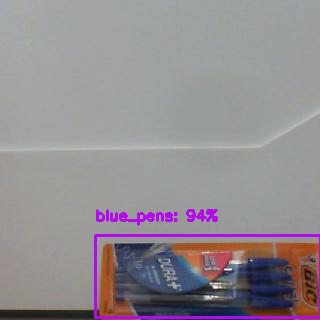

In [ ]:
# Show the detection result
Image.fromarray(detection_result_image)